### Noise robust bird call localisation
## C1 Configuration
### 재구성된 상호상관을 이용한 TDOA 추정
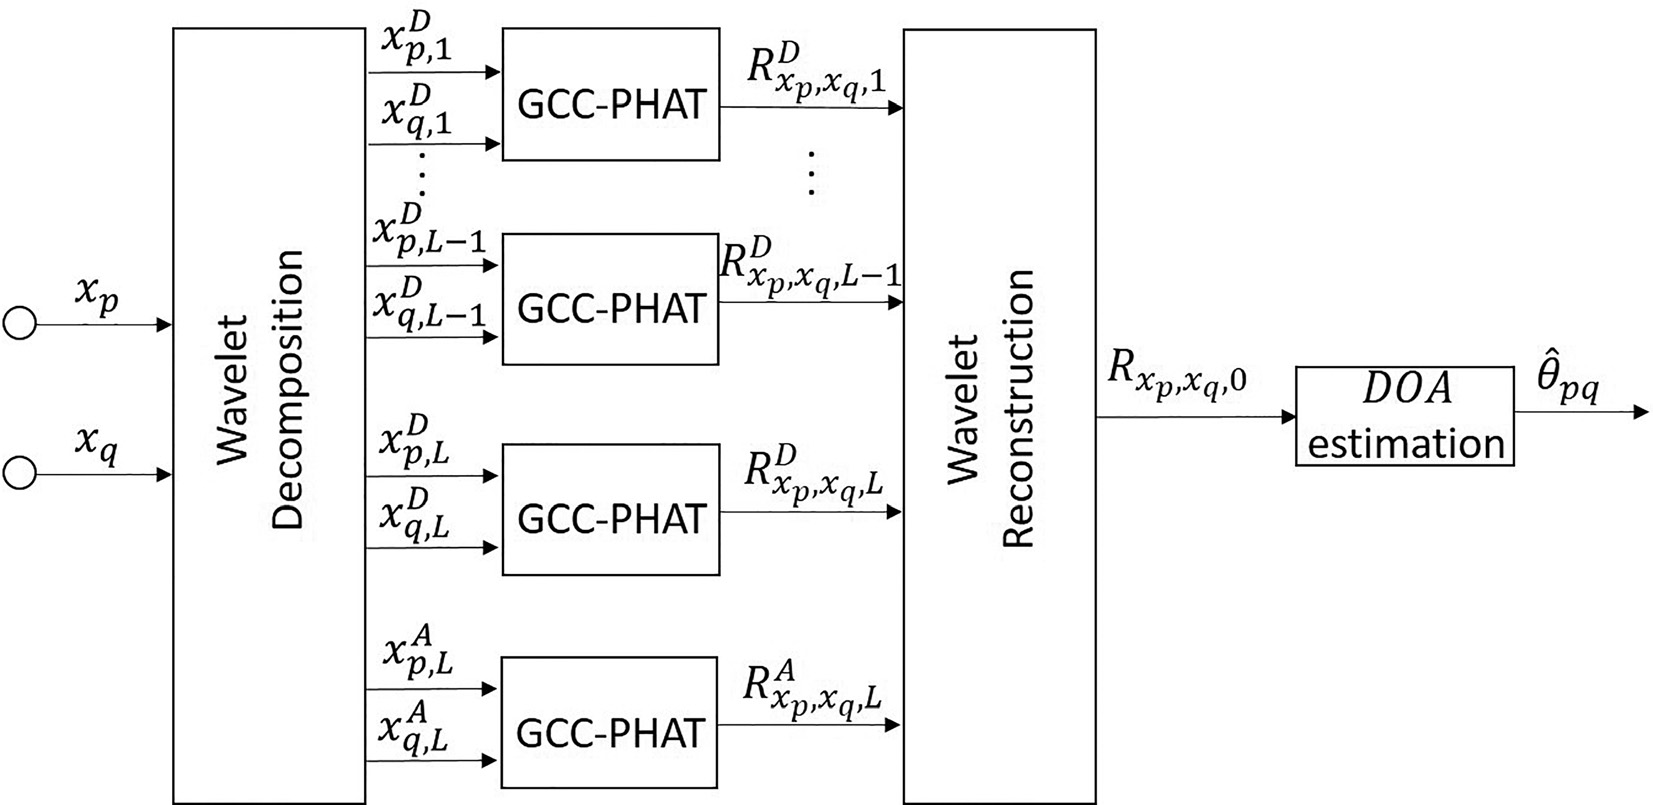
과정
 1. Wavelet 변환 (근사 계수 및 세부 계수 계산)
 2. GCC-PHAT 계산
 3. 교차상관 재구성
 4. DOA 추정

In [764]:
import pywt

In [765]:
# Step 1: Wavelet 변환

# ----- 웨이블릿 변환 관련 함수 -----
def wavelet_decomposition(signal, wavelet='db4', level=2):
    """
    pywt를 이용해 신호를 다중해상도 분해
    """
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

def wavelet_reconstruction(coeffs, wavelet='db4'):
    """
    분해된 웨이블릿 계수를 이용하여 신호를 재구성
    """
    reconstructed_signal = pywt.waverec(coeffs, wavelet)
    return reconstructed_signal

In [766]:
import numpy as np
from scipy.fft import fft, ifft, fftshift

def gcc_phat(sig1, sig2, fs, max_shift=None, epsilon=1e-10):
    """
    GCC-PHAT 기반으로 TDOA(Time Difference of Arrival) 추정
    """
    n = len(sig1)  # 신호 길이만큼 FFT 크기 설정
    sig1_fft = fft(sig1, n=n)
    sig2_fft = fft(sig2, n=n)

    # PHAT 가중치 적용
    cross_spectrum = sig1_fft * np.conj(sig2_fft)
    cross_spectrum /= (np.abs(cross_spectrum) + epsilon)  # 안정성을 위한 작은 값 추가

    # 역 FFT 후 cross-correlation 계산
    cc = np.real(ifft(cross_spectrum, n=n))

    # 중앙 정렬
    cc = fftshift(cc)

    # 최대값 인덱스 찾기
    max_idx = np.argmax(cc)
    delay = max_idx - (n // 2)

    # 최대 지연 범위 제한
    if max_shift is not None:
        delay = np.clip(delay, -max_shift, max_shift)

    return delay / fs  # 초 단위 반환

In [767]:
# ----- Effective Sampling Rate 계산 함수 -----
def get_effective_fs(band_index, level, fs):
    """
    pywt.wavedec의 리턴 배열에서 각 밴드에 해당하는 effective sampling rate를 계산.

    """
    if band_index == 0:
        return fs / (2**level)
    else:
        effective_level = level - band_index + 1
        return fs / (2**(effective_level))

In [768]:
# Step 4: DOA 추정

# ----- DOA 추정 함수 -----
def estimate_doa(tdoa_time, mic_distance, speed_of_sound=343):
    """
    TDOA와 마이크 간 거리를 이용하여 DOA(도착각)를 계산.
    sin 값이 [-1, 1] 범위를 넘어설 경우 clipping을 수행.
    """
    sin_value = (tdoa_time * speed_of_sound) / mic_distance
    if np.abs(sin_value) > 1.0:
        sin_value = np.sign(sin_value)
    angle = np.degrees(np.arcsin(sin_value))
    return np.abs(angle)


In [769]:
# Step 5: 전체 파이프라인 (C1)
def configuration_1(sig1, sig2, fs, mic_distance, wavelet='db4', level=2, max_shift=None):
    """
    C1 방식: 웨이블릿 변환 후 각 대역별 GCC-PHAT 적용,
    각 대역의 effective sampling rate를 고려하여 TDOA 계산 후 평균으로 최종 DOA 산출.
    """
    coeffs1 = wavelet_decomposition(sig1, wavelet, level)
    coeffs2 = wavelet_decomposition(sig2, wavelet, level)
    
    tdoa_list = []
    for i, (band1, band2) in enumerate(zip(coeffs1, coeffs2)):
        eff_fs = get_effective_fs(i, level, fs)
        tdoa = gcc_phat(band1, band2, eff_fs, max_shift)
        tdoa_list.append(tdoa)
        
    final_tdoa = np.mean(tdoa_list)
    doa = estimate_doa(final_tdoa, mic_distance, speed_of_sound=343)
    return doa

# C2 Configuration
Coherence-based weighting 적용

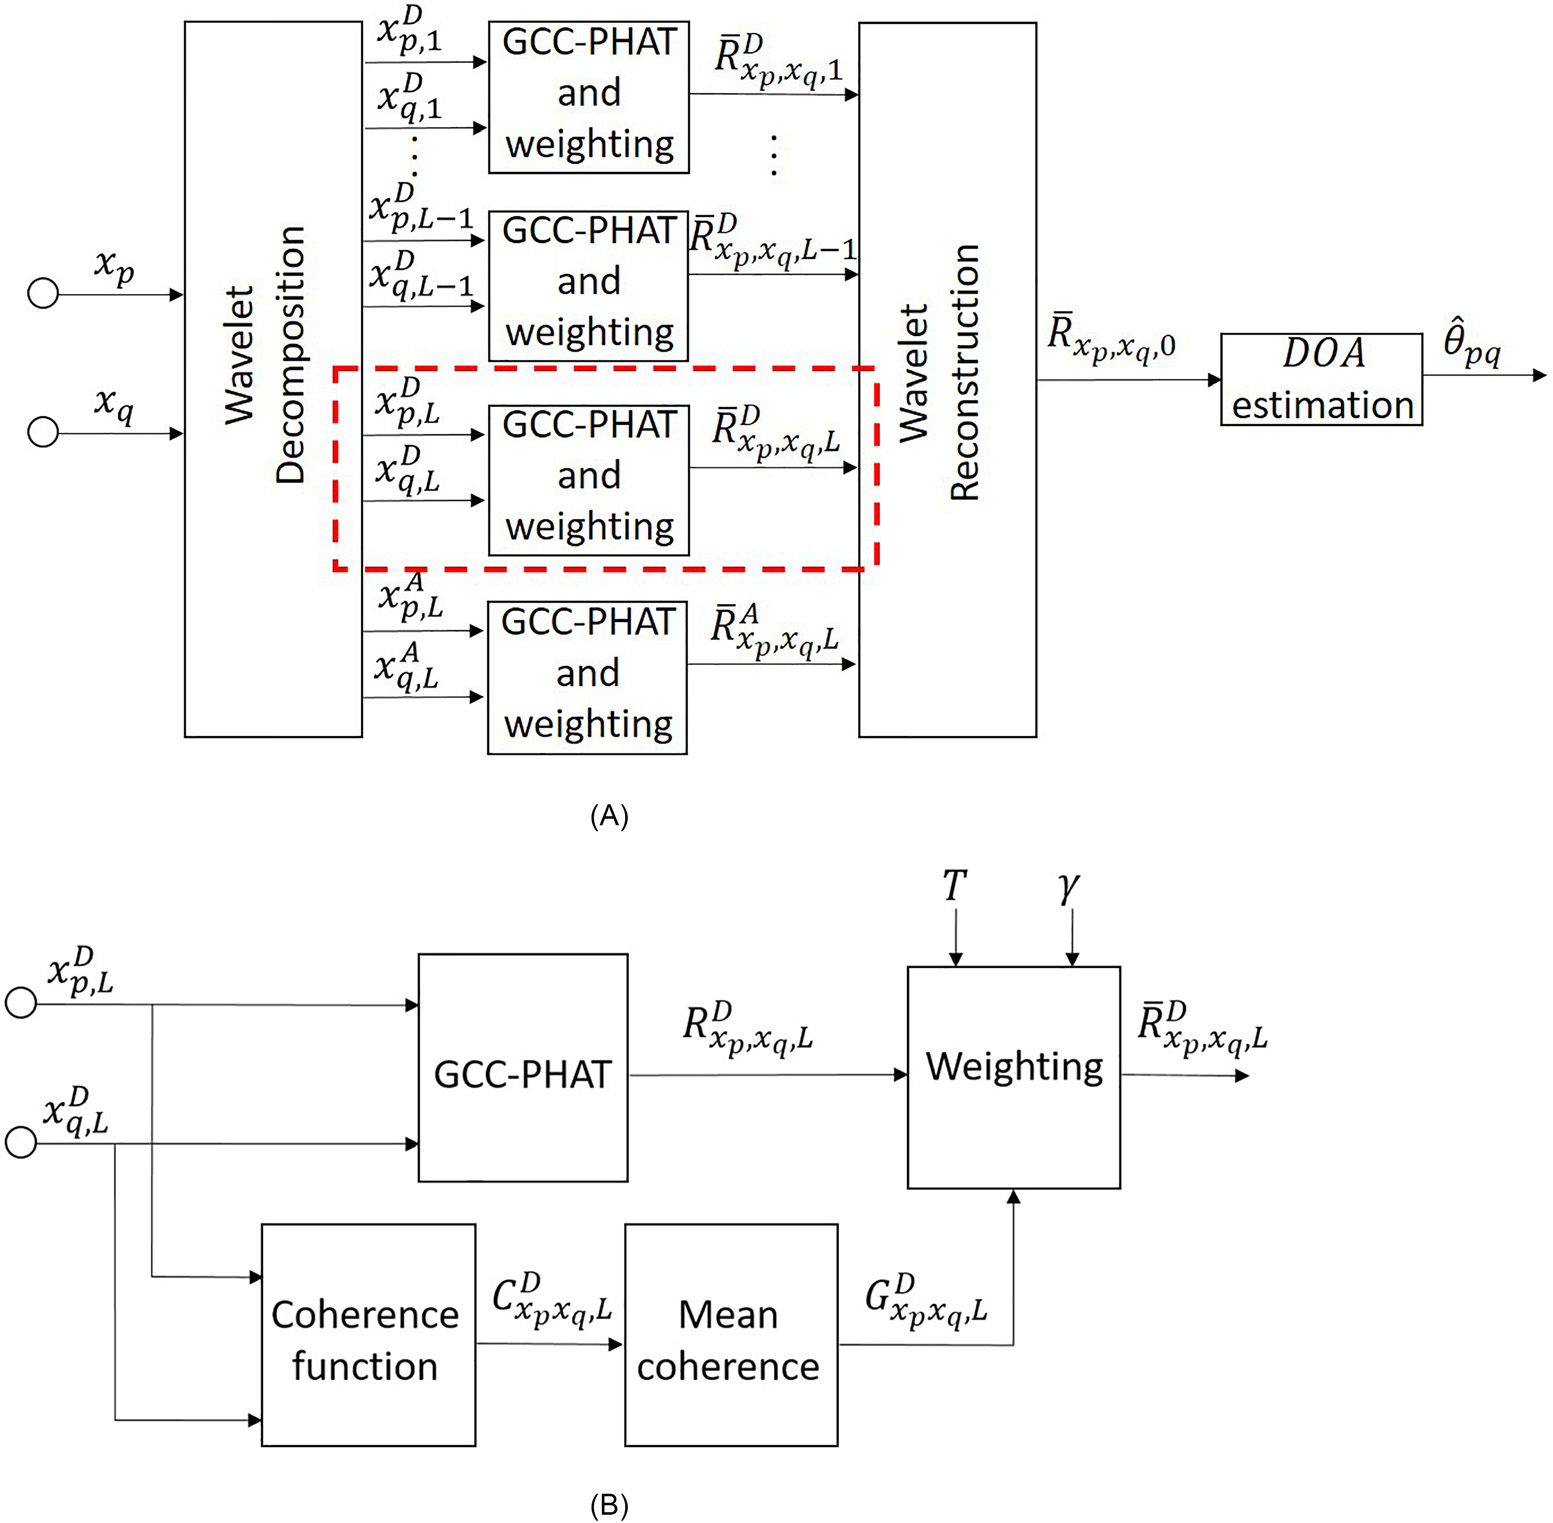

GCC-PHAT로 cross-correlation을 구하는데, coherence를 가중치로 적용하여 신뢰도 높은 신호를 더 강조

In [770]:
import numpy as np
from scipy.signal import coherence

def coherence_function(sig1, sig2, fs, nperseg=None, threshold=0.5):
    """
    두 신호의 주파수 기반 Coherence 계산 후 임계값 이하 성분 제거.
    * threshold: Coherence 임계값(이 값보다 낮으면 잡음으로 간주하여 제거)
    """
    # 신호 길이 확인 및 보정
    min_len = min(len(sig1), len(sig2))
    sig1, sig2 = sig1[:min_len], sig2[:min_len]

    # 신호가 전부 0이면 coherence는 0으로 설정
    if np.all(sig1 == 0) or np.all(sig2 == 0):
        return 0

    # 기본 윈도우 크기 설정 (신호 길이의 1/8, 최소 256)
    if nperseg is None:
        nperseg = max(256, min_len // 8)

    # Coherence 계산 (SciPy 사용)
    f, Cxy = coherence(sig1, sig2, fs=fs, nperseg=nperseg)

    # 임계값 이하의 성분 제거
    Cxy_filtered = np.where(Cxy < threshold, 0, Cxy)

    # 평균 Coherence 값 반환
    return np.mean(Cxy_filtered)


In [771]:
def weighted_correlation(gcc_value, coherence, alpha=2.0):
    """
    Use log scale for coherence to reduce the impact of weak coherence.
    """
    return gcc_value * np.log1p(alpha * coherence)  # log1p to avoid issues with coherence=0

1. Wavelet 변환을 이용해 신호를 여러 대역으로 분해
2. 각 대역에서 GCC-PHAT을 사용하여 TDOA를 계산
3. 각 주파수 대역별 Coherence 값을 계산하여 신뢰도가 높은 대역에 가중치 적용
4. 가중치 적용된 TDOA 값을 재구성하여 최종적인 TDOA 값 추출
5. TDOA 값을 이용해 최종적으로 DOA를 추정

In [772]:
def weighted_gcc_average(gcc_results, coherence_values):
    """
    Use weighted average based on coherence values to compute the final TDOA.
    """
    total_coherence = np.sum(coherence_values)
    if total_coherence > 0:
        return np.sum([g * c for g, c in zip(gcc_results, coherence_values)]) / total_coherence
    return np.mean(gcc_results)  # Fall back to average if no coherence

In [773]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def configuration_2(sig1, sig2, fs, mic_distance, wavelet='db4', level=2):
    """
    C2 방식: 웨이블릿 변환 후 각 대역별 GCC-PHAT 적용,
    coherence 기반 가중치 적용하여 denoised cross-correlation 생성 후 최종 TDOA 추정.
    """
    
    # 1. 웨이블릿 변환 (신호를 다중 해상도로 분해)
    coeffs1 = wavelet_decomposition(sig1, wavelet, level)
    coeffs2 = wavelet_decomposition(sig2, wavelet, level)
    
    gcc_results = []
    coherence_values = []
    
    # 2. 병렬 처리 함수 (각 subband에서 cross-correlation 계산)
    def process_band(band1, band2, eff_fs):
        raw_gcc = gcc_phat(band1, band2, eff_fs)  # 원본 GCC-PHAT cross-correlation
        coherence = coherence_function(band1, band2, eff_fs)  # Coherence 계산
        
        # Apply coherence-based weighting to cross-correlation (denoising)
        weighted_gcc = raw_gcc * coherence  # coherence를 곱하여 디노이징
        
        return weighted_gcc, coherence
    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_band, coeffs1, coeffs2, [get_effective_fs(i, level, fs) for i in range(len(coeffs1))]))

    for weighted_gcc, coherence in results:
        gcc_results.append(weighted_gcc)
        coherence_values.append(coherence)

    # 3. 최종 TDOA 계산 (가중 평균 적용)
    final_tdoa = weighted_gcc_average(gcc_results, coherence_values)

    # 4. TDOA를 기반으로 DOA 계산
    doa = estimate_doa(final_tdoa, mic_distance, speed_of_sound=343)
    
    return doa

# C3 Configuration
Wavelet 변환을 활용한 DOA 추정

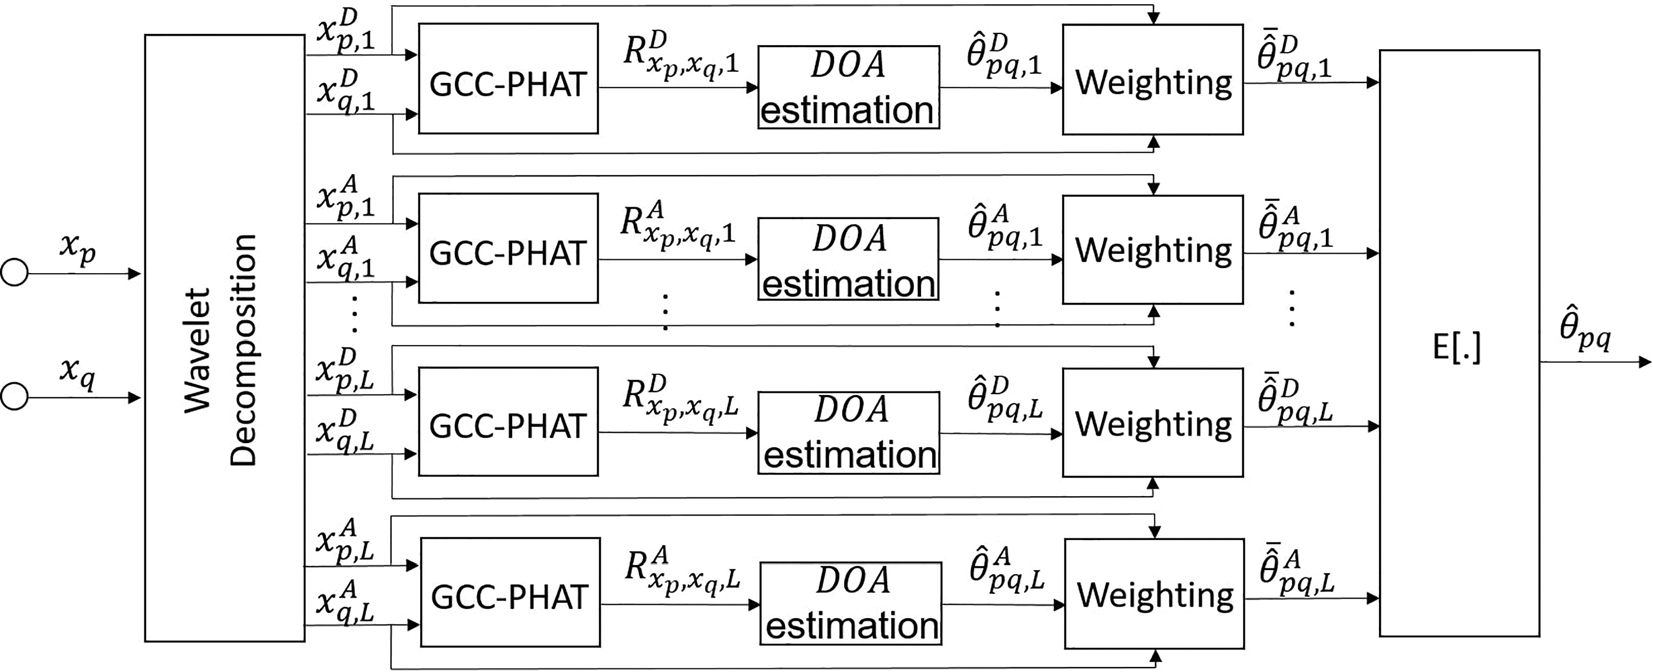

Wavelet 변환을 통해 신호를 다중 해상도로 분해한 후, 각 subband에서 GCC-PHAT을 적용하여 DOA 추정을 하고, coherence 기반 가중치를 적용한 뒤 최종적으로 평균 취함

1. 웨이블릿 변환을 활용한 신호 분해
2. 각 웨이블릿 트리 노드에서 GCC-PHAT을 이용한 TDOA 추정
3. Coherence 기반 가중치 적용
4. 가중 평균을 통한 최종 DOA 결정

In [774]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def configuration_3(sig1, sig2, fs, mic_distance, wavelet='db4', level=2):
    """
    C3 방식: 웨이블릿 변환 후 각 노드에서 개별적으로 DOA를 추정,
    coherence 기반 가중 평균을 통해 최종 DOA 산출.
    """
    
    # 1. 웨이블릿 변환 (신호를 다중 해상도로 분해)
    coeffs1 = wavelet_decomposition(sig1, wavelet, level)
    coeffs2 = wavelet_decomposition(sig2, wavelet, level)
    
    doa_estimates = []
    coherence_values = []
    
    # 2. 각 subband에서 DOA 추정 (병렬 처리)
    def process_band(band1, band2, eff_fs):
        tdoa = gcc_phat(band1, band2, eff_fs)  # GCC-PHAT을 이용한 TDOA 추정
        doa = estimate_doa(tdoa, mic_distance, speed_of_sound=343)  # DOA 변환
        coherence = coherence_function(band1, band2, eff_fs)  # Coherence 계산
        return doa, coherence
    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_band, coeffs1, coeffs2, [get_effective_fs(i, level, fs) for i in range(len(coeffs1))]))
    
    # 3. 결과 저장 및 coherence thresholding
    for doa, coherence in results:
        doa_estimates.append(doa)
        coherence_values.append(coherence)

    # 4. DOA 가중 평균 계산
    sum_coh = np.sum(coherence_values)
    if sum_coh != 0:
        final_doa = np.sum(np.array(doa_estimates) * np.array(coherence_values)) / sum_coh
    else:
        final_doa = np.mean(doa_estimates)  # coherence가 없는 경우 평균 사용
    
    return final_doa

## 실험 환경 설정
-논문에 있는 환경 참조

* angle에 따라 마이크 간 TDOA 계산
* np.roll을 사용해 샘플 지연 적용
* Gaussian 노이즈 추가해 현실적인 실험 환경 모사

실험 환경에 대한 출력
(C1, C2, C3)

In [775]:
def calculate_errors(true_angle, estimated_doa):
    """
    실제 각도와 추정된 DOA 간의 절대 오차와 상대 오차 계산.
    """
    absolute_error = np.abs(true_angle - estimated_doa)
    relative_error = absolute_error / np.abs(true_angle) if true_angle != 0 else 0
    return absolute_error, relative_error

In [776]:
import numpy as np
import logging
from scipy.stats import norm

# 디버깅용 로깅 설정
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

# ----- Gaussian 노이즈 추가 함수 -----
def add_gaussian_noise(signal, snr_db):
    """
    주어진 신호에 Gaussian 노이즈 추가 
    """
    # 원본 신호의 파워 계산
    signal_power = np.sum(signal**2) / len(signal)
    
    # 노이즈의 파워 계산
    snr_linear = 10**(snr_db / 10)  # SNR을 선형 값으로 변환
    noise_power = signal_power / snr_linear
    
    # 노이즈 생성 (정규 분포에서 난수를 샘플링)
    noise = norm.rvs(loc=0, scale=np.sqrt(noise_power), size=len(signal))
    
    # 노이즈를 신호에 추가
    noisy_signal = signal + noise
    return noisy_signal

# ----- 테스트 실행 -----
if __name__ == '__main__':
    # 실험할 다양한 샘플링 주파수 리스트
    sampling_frequencies = [8000,16000,24000]

    mic_distance = 0.1732       # 마이크 간 거리 (m)
    speed_of_sound = 343        # 소리 속도 (m/s)

    for fs in sampling_frequencies:
        print(f"\n샘플링 주파수: {fs} Hz")
        
        # 실제 DOA (0 ~ 90° 사이 랜덤 선택)
        true_angle = np.random.uniform(0, 60)
        print(f"실제 각도: {true_angle:.4f}°")
        
        # 1초 길이의 백색잡음 신호 생성
        np.random.seed(1)  # 재현성을 위해 시드 고정
        sig1 = np.random.randn(fs)
        
        # Gaussian 노이즈 추가 (SNR: 0 dB로 설정)
        snr_db = 0
        sig1_noisy = add_gaussian_noise(sig1, snr_db)
        
        # 실제 DOA에 따른 TDOA 적용
        tdoa_sec = (mic_distance * np.sin(np.radians(true_angle))) / speed_of_sound
        tdoa_samples = int(tdoa_sec * fs)
        sig2 = np.roll(sig1_noisy, tdoa_samples)
        
        # GCC-PHAT 방식 TDOA 계산 및 DOA 추정
        tdoa_gcc_phat = gcc_phat(sig1_noisy, sig2, fs)
        doa_gcc_phat = estimate_doa(tdoa_gcc_phat, mic_distance, speed_of_sound)
    
        # Configuration 방식으로 DOA 추정 (더미 함수 사용)
        doa_c1 = configuration_1(sig1_noisy, sig2, fs, mic_distance, wavelet='db4', level=2, max_shift=fs//100)
        doa_c2 = configuration_2(sig1_noisy, sig2, fs, mic_distance, wavelet='db4', level=2)
        doa_c3 = configuration_3(sig1_noisy, sig2, fs, mic_distance, wavelet='db4', level=2)
        
        # 추정된 DOA 출력
        print(f"GCC-PHAT 방식 추정 DOA: {doa_gcc_phat:.4f}°")
        print(f"Configuration 1 추정 DOA: {doa_c1:.4f}°")
        print(f"Configuration 2 추정 DOA: {doa_c2:.4f}°")
        print(f"Configuration 3 추정 DOA: {doa_c3:.4f}°")
        
        # 추정 오차 계산
        abs_error_gcc_phat, rel_error_gcc_phat = calculate_errors(true_angle, doa_gcc_phat)
        abs_error_c1, rel_error_c1 = calculate_errors(true_angle, doa_c1)
        abs_error_c2, rel_error_c2 = calculate_errors(true_angle, doa_c2)
        abs_error_c3, rel_error_c3 = calculate_errors(true_angle, doa_c3)
        
        print(f"GCC-PHAT 추정 오차: 절대 오차 = {abs_error_gcc_phat:.4f}°, 상대 오차 = {rel_error_gcc_phat:.4f}")
        print(f"Configuration 1 추정 오차: 절대 오차 = {abs_error_c1:.4f}°, 상대 오차 = {rel_error_c1:.4f}")
        print(f"Configuration 2 추정 오차: 절대 오차 = {abs_error_c2:.4f}°, 상대 오차 = {rel_error_c2:.4f}")
        print(f"Configuration 3 추정 오차: 절대 오차 = {abs_error_c3:.4f}°, 상대 오차 = {rel_error_c3:.4f}")



샘플링 주파수: 8000 Hz
실제 각도: 51.0851°
GCC-PHAT 방식 추정 DOA: 47.9567°
Configuration 1 추정 DOA: 41.3093°
Configuration 2 추정 DOA: 25.2959°
Configuration 3 추정 DOA: 50.4336°
GCC-PHAT 추정 오차: 절대 오차 = 3.1284°, 상대 오차 = 0.0612
Configuration 1 추정 오차: 절대 오차 = 9.7758°, 상대 오차 = 0.1914
Configuration 2 추정 오차: 절대 오차 = 25.7892°, 상대 오차 = 0.5048
Configuration 3 추정 오차: 절대 오차 = 0.6515°, 상대 오차 = 0.0128

샘플링 주파수: 16000 Hz
실제 각도: 8.7431°
GCC-PHAT 방식 추정 DOA: 7.1099°
Configuration 1 추정 DOA: 4.7332°
Configuration 2 추정 DOA: 3.9073°
Configuration 3 추정 DOA: 5.5507°
GCC-PHAT 추정 오차: 절대 오차 = 1.6332°, 상대 오차 = 0.1868
Configuration 1 추정 오차: 절대 오차 = 4.0099°, 상대 오차 = 0.4586
Configuration 2 추정 오차: 절대 오차 = 4.8358°, 상대 오차 = 0.5531
Configuration 3 추정 오차: 절대 오차 = 3.1924°, 상대 오차 = 0.3651

샘플링 주파수: 24000 Hz
실제 각도: 56.4479°
GCC-PHAT 방식 추정 DOA: 55.6041°
Configuration 1 추정 DOA: 45.6541°
Configuration 2 추정 DOA: 37.8790°
Configuration 3 추정 DOA: 52.4964°
GCC-PHAT 추정 오차: 절대 오차 = 0.8438°, 상대 오차 = 0.0149
Configuration 1 추정 오차: 절대 오차 = 10.7938°, 상